In [194]:
import torch
import numpy as np
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
try :
  import torchinfo
except :
  !pip install torchinfo
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from IPython.display import clear_output
np.float64()
try :
  from torch.utils.tensorboard import SummaryWriter
except :
  !pip install tensorboard

from torch.utils.tensorboard import SummaryWriter
from typing import Optional

In [195]:


# ---------------------------- DATA ---------------------------- #

# Sample data
x = np.array([i for i in range(1, 51)])
y = np.array([
    5.76, 5.85, 8.88, 2.39, 8.29, 16.13, 11.65, 16.36, 15.65, 21.36,
    20.65, 20.96, 27.12, 30.92, 18.61, 24.88, 28.34, 31.26, 38.32, 36.44,
    40.67, 44.39, 40.11, 37.01, 49.60, 48.99, 54.67, 56.35, 65.35, 64.13,
    64.86, 71.61, 69.45, 73.54, 80.40, 67.99, 85.27, 76.28, 79.64, 75.70,
    73.27, 79.45, 74.12, 86.81, 86.65, 96.99, 92.00, 92.70, 90.50, 97.11
])

BATCH_SIZE = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Convert to torch tensors (float32) and add a feature dimension (N, 1)
x_tensor = torch.from_numpy(x).float().unsqueeze(1)  # shape (50, 1)
y_tensor = torch.from_numpy(y).float().unsqueeze(1)  # shape (50, 1)

# Create dataset
dataset = TensorDataset(x_tensor, y_tensor)

# ---------------------------- PLOT FUNCTION ---------------------------- #

def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
    Plots linear training data and test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=20, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=20, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=20, label="Predictions")

    plt.legend(prop={"size": 14})
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Training / Test data and predictions")
    plt.grid(True)
    plt.show()

# ---------------------------- SPLIT & DATALOADERS ---------------------------- #

torch.manual_seed(42)

TRAIN_SIZE = int(0.8 * len(dataset))  # 80% train, 20% test
TEST_SIZE = len(dataset) - TRAIN_SIZE

train_dataset, test_dataset = random_split(dataset, [TRAIN_SIZE, TEST_SIZE])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


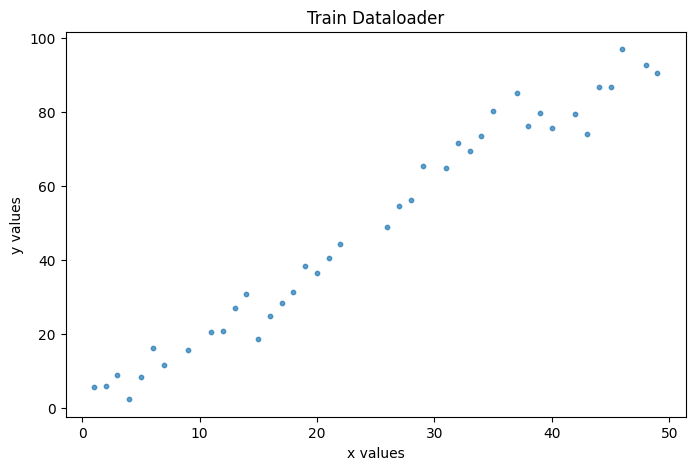

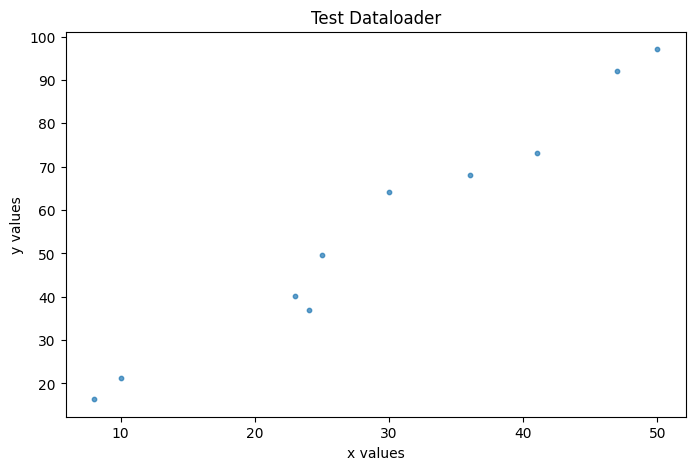

In [196]:
# Visualisation des données
def visualize_dataloader(dataloader, title):
    x_vals, y_vals = [], []
    for x, y in dataloader:
        x_vals.append(x.flatten())
        y_vals.append(y)
    x_vals = torch.cat(x_vals).numpy()
    y_vals = torch.cat(y_vals).numpy()

    plt.figure(figsize=(8, 5))
    plt.scatter(x_vals, y_vals, s=10, alpha=0.7)
    plt.xlabel("x values")
    plt.ylabel("y values")
    plt.title(title)
    plt.show()

# Visualiser le train_dataloader
visualize_dataloader(train_dataloader, "Train Dataloader")

# Visualiser le test_dataloader
visualize_dataloader(test_dataloader, "Test Dataloader")

# Model

In [197]:

class NN1(nn.Module):
  """
    Base class for 2-layer networks with explicitly parameterized weights
    and a configurable nonlinearity and positivity transform.

    W1, W2 are unconstrained parameters; a positivity transform is applied
    in the forward pass (e.g. softplus or square) to enforce W >= 0.

    Sigmoid activation.
  """
  def __init__(self, in_features = 1, hidden_features = 8, out_features = 1):
    super().__init__()

    self.W1 = nn.Parameter(torch.randn(hidden_features, in_features)+1)
    self.b1 = nn.Parameter(torch.zeros(hidden_features))

    self.W2 = nn.Parameter(torch.randn(out_features, hidden_features))
    self.b2 = nn.Parameter(torch.zeros(out_features))


  def forward(self, x):
    pos_w1 = F.softplus(self.W1)
    pos_w2 = F.softplus(self.W2)
    a = torch.sigmoid(F.linear(x,pos_w1,self.b1))
    x = F.linear(a,pos_w2,self.b2)
    return x

class NN2(nn.Module):
  """
    Base class for 2-layer networks with explicitly parameterized weights
    and a configurable nonlinearity and positivity transform.

    W1, W2 are unconstrained parameters; a positivity transform is applied
    in the forward pass (e.g. softplus or square) to enforce W >= 0.

    Relu activation.
  """
  def __init__(self, in_features = 1, hidden_features = 8, out_features = 1):
    super().__init__()

    self.W1 = nn.Parameter(torch.randn(hidden_features, in_features)+1)
    self.b1 = nn.Parameter(torch.zeros(hidden_features))

    self.W2 = nn.Parameter(torch.randn(out_features, hidden_features))
    self.b2 = nn.Parameter(torch.zeros(out_features))
    self.relu = nn.ReLU()


  def forward(self, x):
    pos_w1 = F.softplus(self.W1)
    pos_w2 = F.softplus(self.W2)
    a = self.relu(F.linear(x,pos_w1,self.b1))
    x = F.linear(a,pos_w2,self.b2)
    return x



In [198]:
model1 = NN1(in_features = 1, hidden_features = 32, out_features = 1).to(device)
model2 = NN2(in_features = 1, hidden_features = 32, out_features = 1).to(device)

# Train Model

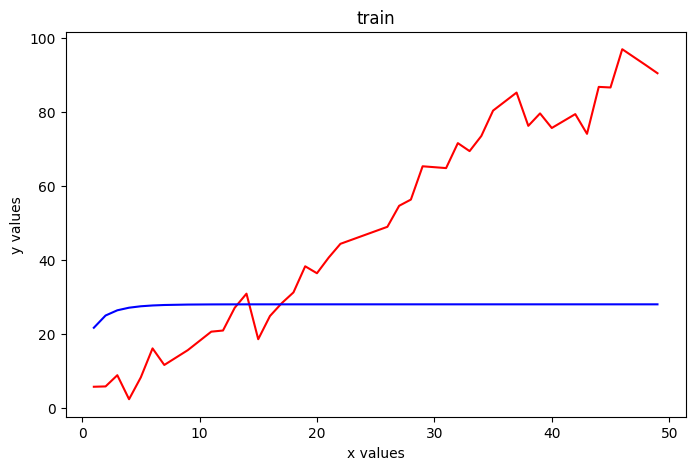

In [199]:
# Visualisation des données
def visualize_true_pred(model, dataloader, title):
    model.eval()
    x_vals, y_vals, pred_vals = [], [], []
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            pred = model(X)

            x_vals.append(X.flatten())
            y_vals.append(y)
            pred_vals.append(pred)


    x_vals = torch.cat(x_vals).numpy()
    y_vals = torch.cat(y_vals).numpy()
    pred_vals = torch.cat(pred_vals).numpy()

    sorted_indices = np.argsort(x_vals)
    x_vals = x_vals[sorted_indices]
    y_vals = y_vals[sorted_indices]
    pred_vals = pred_vals[sorted_indices]

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, y_vals, c='r')
    plt.plot(x_vals, pred_vals, c = 'b')

    plt.xlabel("x values")
    plt.ylabel("y values")
    plt.title(title)
    plt.show()

visualize_true_pred(model1, train_dataloader, "train")


In [200]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 1. do the forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    return train_loss

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval()
    test_loss = 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    return test_loss


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    results = {"train_loss": [],
               "test_loss": [],
    }




    model.to(device)

    for epoch in tqdm(range(epochs), desc = "Training progress"):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)
        test_loss  = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn,
                              device=device)


        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")


        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    # Plotting outside the loop
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(range(1, epochs + 1), results["train_loss"], label="Train Loss", color='b')
    ax.plot(range(1, epochs + 1), results["test_loss"], label="Test Loss", color='r')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Training and Testing Loss over Epochs")
    ax.legend()
    ax.grid(True)
    plt.show()




    return results

In [201]:
model1.eval()
with torch.no_grad():
    y_pred = model1(x_tensor).squeeze()
    y_true = y_tensor.squeeze()

criterion = torch.nn.MSELoss()
mse = criterion(y_pred, y_true).item()

print("Final MSE:", mse)

Final MSE: 1322.34912109375


In [202]:
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=0.01, weight_decay=1e-4)
my_loss_fn = nn.MSELoss()

In [ ]:
results = train(model = model1,
          train_dataloader = train_dataloader,
          test_dataloader = test_dataloader,
          optimizer = optimizer1,
          loss_fn = my_loss_fn,
          epochs = 1500,
          device = device)

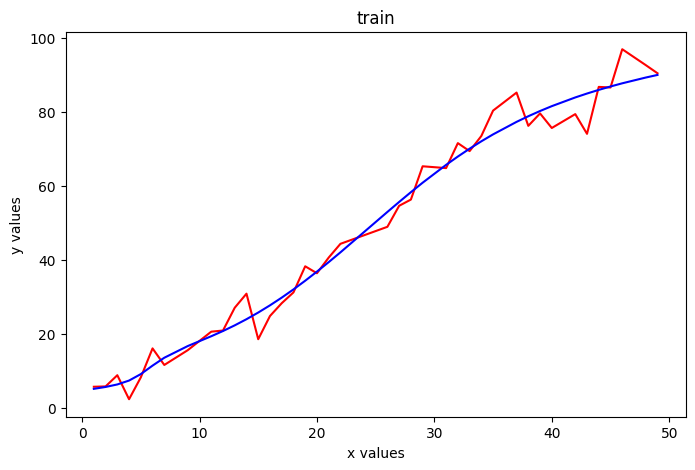

In [204]:
visualize_true_pred(model1, train_dataloader, "train")

# Pav Algorithm

Original y values: [ 5.76  5.85  8.88  2.39  8.29 16.13 11.65 16.36 15.65 21.36 20.65 20.96
 27.12 30.92 18.61 24.88 28.34 31.26 38.32 36.44 40.67 44.39 40.11 37.01
 49.6  48.99 54.67 56.35 65.35 64.13 64.86 71.61 69.45 73.54 80.4  67.99
 85.27 76.28 79.64 75.7  73.27 79.45 74.12 86.81 86.65 96.99 92.   92.7
 90.5  97.11]
Isotonic y values: [ 5.72        5.72        5.72        5.72        8.29       13.89
 13.89       16.005      16.005      20.99       20.99       20.99
 25.3825     25.3825     25.3825     25.3825     28.34       31.26
 37.38       37.38       40.545      40.545      40.545      40.545
 49.295      49.295      54.67       56.35       64.74       64.74
 64.86       70.53       70.53       73.54       74.195      74.195
 77.67571429 77.67571429 77.67571429 77.67571429 77.67571429 77.67571429
 77.67571429 86.73       86.73       93.0475     93.0475     93.0475
 93.0475     97.11      ]


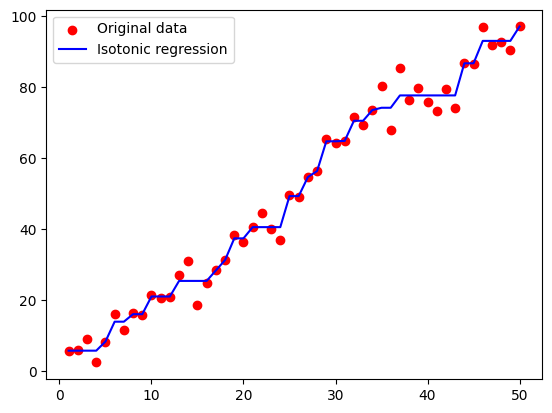

In [205]:
# Create an instance of IsotonicRegression and fit the model
iso_reg = IsotonicRegression(increasing=True)
y_iso = iso_reg.fit_transform(x, y)

# Print the results
print("Original y values:", y)
print("Isotonic y values:", y_iso)

# Plot the results
plt.scatter(x, y, label="Original data", color="red")
plt.plot(x, y_iso, label="Isotonic regression", color="blue")
plt.legend()
plt.show()

In [206]:
y_t = torch.tensor(y, dtype=torch.float32)
y_iso_t = torch.tensor(y_iso, dtype=torch.float32)

criterion = nn.MSELoss()

mse = criterion(y_t, y_iso_t)
print("MSE:", mse.item())


MSE: 6.936071872711182


In [207]:
model1.eval()
with torch.no_grad():
    y_pred = model1(x_tensor).squeeze()
    y_true = y_tensor.squeeze()

criterion = torch.nn.MSELoss()
mse = criterion(y_pred, y_true).item()

print("Final MSE:", mse)

Final MSE: 20.1090145111084


Interpretation : In order to get the accurate function ( not quite soft ), we need to increase the number of neurons.